### Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math

### Algorithm Architecture

#### GARCH architecture

In [0]:
###### Define GARCH Recursion ######
def garch_filter(alpha0, alpha1, alpha2, beta1, beta2, eps):
    iT = len(eps)
    sigma_2 = np.zeros(iT)
    
    for i in range(iT):
        if i == 0:
            sigma_2[i] = alpha0/(1 - alpha1 - beta1)
        elif i == 1:
            sigma_2[i] = alpha0 + alpha1*eps[i-1]**2 + beta1*sigma_2[i-1]
        else:
            sigma_2[i] = alpha0 + alpha1*eps[i-1]**2 + alpha2*eps[i-2]**2 + beta1*sigma_2[i-1] + beta2*sigma_2[i-2]
            
    return sigma_2


#### Log Likelihood function

In [0]:
###### Define GARCH log-likelihood ######
def garch_loglike(vP,eps):
    
    iT = len(eps)
    alpha0 = vP[0]
    alpha1 = vP[1]
    alpha2 = vP[2]
    beta1 = vP[3]
    beta2 = vP[4]
    
    sigma_2 = garch_filter(alpha0, alpha1, alpha2, beta1, beta2, eps)
    
    #LogL = -np.sum(-np.log(sigma_2) - [ep**2 for ep in eps]/sigma_2)
    LogL = -np.sum(-np.log(sigma_2) - eps**2/sigma_2)
    return LogL

### Data

In [5]:
### Past 6 years of nse data from 1st Jan 2014 to 31st Dec 2019
url = 'https://raw.githubusercontent.com/Somil-Gupta/MLE_GARCH/master/nse.csv'
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
df.head()

,NSE,Returns
Date,,
2014-01-03,6211.149902,-0.001609
2014-01-06,6191.450195,-0.003177
2014-01-07,6162.250000,-0.004727
2014-01-08,6174.600098,0.002002
2014-01-09,6168.350098,-0.001013


In [0]:
returns = df['Returns'].values
dates = df.index.values

### MLE optimization using scipy optimization

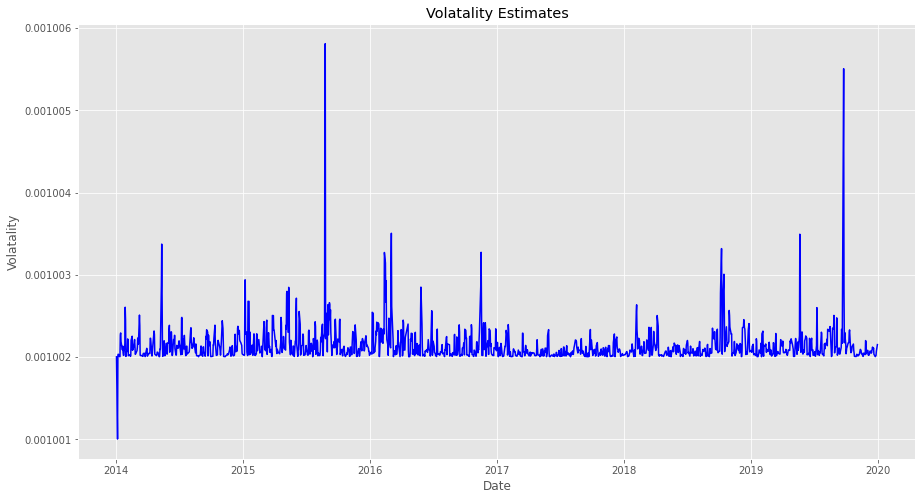

In [7]:
#### We are using quasi MLE
cons = ({'type': 'ineq', 'func': lambda x: np.array(x)})
vP0 = (0.1, 0.05, 0.03, 0.92, 0.6)
res = opt.minimize(garch_loglike, vP0, args = (returns),
              bounds = ((0.001, None), (0.001, None), (0.001, None), (0.001, None), (0.001, None)),
              options = {'disp': True})
alpha0_est = res.x[0]
alpha1_est = res.x[1]
alpha2_est = res.x[2]
beta1_est = res.x[3]
beta2_est = res.x[4]

sigma2 = garch_filter(alpha0_est, alpha1_est, alpha2_est, beta1_est, beta2_est, returns)
plt.figure(figsize=(15,8))
plt.style.use('ggplot')
plt.plot(dates, sigma2, color = 'b')
plt.title('Volatality Estimates')
plt.xlabel("Date")
plt.ylabel("Volatality")
plt.show()